In [1]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
%tensorflow_version 1.15

from matplotlib import pyplot as plt

MAX_INPUT_LENGTH = 100
N_CONV_FILTERS = 10
EMBEDDING_SIZE = 20
FILTER_SHAPE1_CHAR = [20, 256]
FILTER_SHAPE1_WORD = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
BATCH_SIZE = 128

NO_OF_EPOCHS = 100
LEARNING_RATE = 0.01

tf.logging.set_verbosity(tf.logging.ERROR)
seed = 10
tf.set_random_seed(seed)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# Function to read data from CSV file
def read_data(encoding_level):
  # Get Pandas dataframe
  raw_data_train = pd.read_csv('train_medium.csv', names=["Category", "Wikipedia Page", "Paragraph Text"])
  raw_data_test = pd.read_csv('test_medium.csv', names=["Category", "Wikipedia Page", "Paragraph Text"])

  # Slice Pandas dataframe to get input and output attribute
  if encoding_level == "char":
    input_text_train, input_text_test = pd.Series(raw_data_train["Wikipedia Page"]), pd.Series(raw_data_test["Wikipedia Page"])
  elif encoding_level == "word":
    input_text_train, input_text_test = pd.Series(raw_data_train["Paragraph Text"]), pd.Series(raw_data_test["Paragraph Text"])
  output_label_train, output_label_test = pd.Series(raw_data_train["Category"]), pd.Series(raw_data_test["Category"])

  # Encode character to text
  if encoding_level == "char":
    encoder = tf.contrib.learn.preprocessing.ByteProcessor(MAX_INPUT_LENGTH)
  elif encoding_level == "word":
    encoder = tf.contrib.learn.preprocessing.VocabularyProcessor(MAX_INPUT_LENGTH)

  x_train = np.array(list(encoder.fit_transform(input_text_train)), dtype=np.uint8)
  y_train = np.array(output_label_train, dtype=np.uint8).reshape((-1, 1))

  x_test = np.array(list(encoder.fit_transform(input_text_test)), dtype=np.uint8)
  y_test = np.array(output_label_test, dtype=np.uint8).reshape((-1, 1))

  if encoding_level == "word":
    no_of_words = len(encoder.vocabulary_)
  else:
    no_of_words = 0

  return x_train, y_train, x_test, y_test, no_of_words

In [0]:
def cnn_model(x, encoding_level, no_of_words=None, use_dropout=False):
  dropout_rate = tf.placeholder(tf.float32)

  # Initially pass through embedding layer if CNN model is word-level
  if encoding_level == "word":
    embedding = tf.contrib.layers.embed_sequence(x, vocab_size=no_of_words, embed_dim=EMBEDDING_SIZE)
    # Input layer
    input_layer = tf.reshape(embedding, [-1, MAX_INPUT_LENGTH, EMBEDDING_SIZE, 1])
  elif encoding_level == "char":
    # Input layer
    input_layer = tf.reshape(tf.one_hot(x, 256), [-1, MAX_INPUT_LENGTH, 256, 1])

  # First CNN layer
  # Convolution layer
  if encoding_level == "char":
    conv1 = tf.layers.conv2d(input_layer, filters=N_CONV_FILTERS, kernel_size=FILTER_SHAPE1_CHAR, padding='VALID', activation=tf.nn.relu)
  elif encoding_level == "word":
    conv1 = tf.layers.conv2d(input_layer, filters=N_CONV_FILTERS, kernel_size=FILTER_SHAPE1_WORD, padding='VALID', activation=tf.nn.relu)
  
  # Pooling layer
  pool1 = tf.layers.max_pooling2d(conv1, pool_size=POOLING_WINDOW, strides=POOLING_STRIDE, padding='SAME')
  
  # Optional dropout layer
  if use_dropout:
    pool1 = tf.nn.dropout(pool1, rate=dropout_rate)

  # Second CNN layer
  # Convolution layer
  conv2 = tf.layers.conv2d(pool1, filters=N_CONV_FILTERS, kernel_size=FILTER_SHAPE2, padding='VALID', activation=tf.nn.relu)

  # Pooling layer
  pool2 = tf.layers.max_pooling2d(conv2, pool_size=POOLING_WINDOW, strides=POOLING_STRIDE, padding='SAME')
  
  # Optional dropout layer
  if use_dropout:
      pool2 = tf.nn.dropout(pool2, rate=dropout_rate)

  pool2 = tf.squeeze(tf.reduce_max(pool2, 1), squeeze_dims=[1])

  # Output layer
  logits = tf.layers.dense(pool2, MAX_LABEL, activation=None)

  return input_layer, logits, dropout_rate

In [0]:
def plot_graph(title, fig_title, question_no, data_list, y_label, legend_labels):
  fig, ax = plt.subplots()
  for data, label in zip(data_list, legend_labels):
    ax.plot(list(range(1, NO_OF_EPOCHS + 1)), data, label=label)
  legend = ax.legend(loc='best')

  plt.xlabel(str(NO_OF_EPOCHS) +' iterations')
  plt.ylabel(y_label)
  plt.title(title)
  plt.savefig('figures/project_2b_q{}_{}'.format(question_no, fig_title))

In [0]:
def training(encoding_level, use_dropout=False, use_timer=False):
  # Read and encode data
  x_train, y_train, x_test, y_test, no_of_words = read_data(encoding_level)

  # Reseed so shuffled data for mini-batch gradient descent are consistent with each training
  np.random.seed(seed)

  # Create the model
  x = tf.placeholder(tf.int64, [None, MAX_INPUT_LENGTH])
  y_ = tf.placeholder(tf.int64, [None, 1])

  _, logits, dropout_rate = cnn_model(x, encoding_level, no_of_words=no_of_words, use_dropout=use_dropout)

  # Optimizer
  entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
  train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(entropy)

  # Accuracy
  accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.reshape(tf.argmax(logits, 1), [-1, 1]), y_), tf.float32))

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # training
    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    # Start timer
    if use_timer:
      start_time = time.time()

    for e in range(NO_OF_EPOCHS):
      # Shuffle the dataset before grouping them into minibatches for gradient updates
      dataset_size = x_train.shape[0]
      idx = np.arange(dataset_size)
      np.random.shuffle(idx)
      x_shuffled, y_shuffled = x_train[idx], y_train[idx]

      for start, end in zip(range(0, len(x_train), BATCH_SIZE), range(BATCH_SIZE, len(x_train), BATCH_SIZE)):
        _ = sess.run(train_op, feed_dict={x: x_shuffled[start:end], y_: y_shuffled[start:end], dropout_rate: 0.2})
      
      train_loss_, train_accuracy_ = sess.run([entropy, accuracy], feed_dict={x: x_train, y_: y_train, dropout_rate: 0})
      train_losses.append(train_loss_)
      train_accuracies.append(train_accuracy_)

      test_loss_, test_accuracy_ = sess.run([entropy, accuracy], feed_dict={x: x_test, y_: y_test, dropout_rate: 0})
      test_losses.append(test_loss_)
      test_accuracies.append(test_accuracy_)

      if e % 1 == 0:
        print('iter: %d, train_entropy: %g, train_accuracy: %g, test_entropy: %g, test_accuracy: %g' % (e, train_losses[e], train_accuracies[e], test_losses[e], test_accuracies[e]))
    
    if use_timer:
      end_time = time.time() - start_time
    else:
      end_time = 0

  return train_losses, train_accuracies, test_losses, test_accuracies, end_time

In [0]:
def main():
  # Train Character CNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies, end_time_char = training(encoding_level='char', use_timer=True)

  print("=========== Char-CNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print("Time taken to train: {} seconds".format(end_time_char))
  print()

  plot_graph(title="Character-CNN Model Learning Curve", 
             fig_title="char_cnn_learning_curve", 
             question_no="1", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character-CNN Model Accuracy vs Epochs", 
             fig_title="char_cnn_accuracy", 
             question_no="1", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])

  # Train Word CNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies, end_time_word = training(encoding_level='word', use_timer=True)
  
  print("=========== Word-CNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print("Time taken to train: {} seconds".format(end_time_word))
  print()

  plot_graph(title="Word-CNN Model Learning Curve",
             fig_title="word_cnn_learning_curve",
             question_no="2",
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word-CNN Model Accuracy vs Epochs",
             fig_title="word_cnn_accuracy",
             question_no="2",
             data_list=[train_accuracies, test_accuracies],
             y_label="Accuracy",
             legend_labels=["Train", "Test"])
  
  plt.clf()

  # Plot histogram
  models = ['Char-CNN', 'Word-CNN']
  y_pos = np.arange(len(models))
  times = [end_time_char, end_time_word]

  plt.bar(models, times, align='center', alpha=0.5)
  plt.xticks(y_pos, models)
  plt.ylabel('Time taken to train')
  plt.title('Time taken to train vs model')
  plt.savefig('figures/project_2b_q5_cnn_time.png')

  plt.clf()

  # Train Character CNN model with dropout
  entropy_losses, train_accuracies, test_losses, test_accuracies, _ = training(encoding_level='char', use_dropout=True)
  
  print("=========== Char-CNN with Dropout ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Character-CNN Model Learning Curve w/ Dropout",
             fig_title="char_cnn_learning_curve_dropout",
             question_no="5",
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character-CNN Model Accuracy vs Epochs w/ Dropout",
             fig_title="char_cnn_accuracy_dropout",
             question_no="5",
             data_list=[train_accuracies, test_accuracies],
             y_label="Accuracy",
             legend_labels=["Train", "Test"])

  # Train Word CNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies, _ = training(encoding_level='word', use_dropout=True)
  
  print("=========== Word-CNN with Dropout ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Word-CNN Model Learning Curve w/ Dropout",
             fig_title="word_cnn_learning_curve_dropout", 
             question_no="5",
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word-CNN Model Accuracy vs Epochs w/ Dropout",
             fig_title="word_cnn_accuracy_dropout",
             question_no="5",
             data_list=[train_accuracies, test_accuracies],
             y_label="Accuracy",
             legend_labels=["Train", "Test"])

iter: 0, train_entropy: 2.29674, train_accuracy: 0.244464, test_entropy: 2.35406, test_accuracy: 0.227143
iter: 1, train_entropy: 1.85173, train_accuracy: 0.364643, test_entropy: 2.03456, test_accuracy: 0.302857
iter: 2, train_entropy: 1.53474, train_accuracy: 0.477143, test_entropy: 1.87806, test_accuracy: 0.36
iter: 3, train_entropy: 1.2731, train_accuracy: 0.561071, test_entropy: 1.79492, test_accuracy: 0.394286
iter: 4, train_entropy: 1.14277, train_accuracy: 0.603214, test_entropy: 1.83539, test_accuracy: 0.415714
iter: 5, train_entropy: 1.00143, train_accuracy: 0.650714, test_entropy: 1.89098, test_accuracy: 0.42
iter: 6, train_entropy: 0.964818, train_accuracy: 0.657679, test_entropy: 1.96896, test_accuracy: 0.407143
iter: 7, train_entropy: 0.848907, train_accuracy: 0.708036, test_entropy: 2.03209, test_accuracy: 0.43
iter: 8, train_entropy: 0.790131, train_accuracy: 0.725179, test_entropy: 2.13268, test_accuracy: 0.432857
iter: 9, train_entropy: 0.725103, train_accuracy: 0.7494

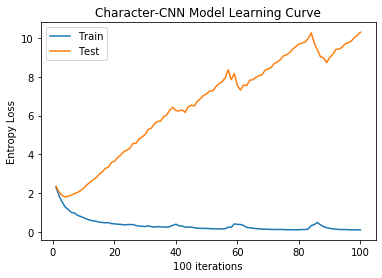

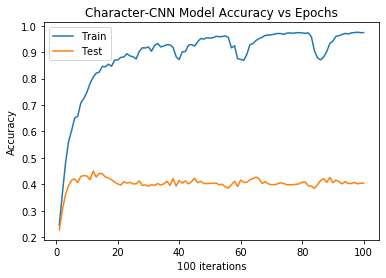

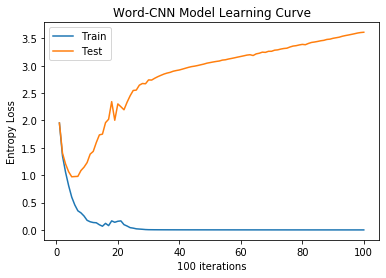

<Figure size 432x288 with 0 Axes>

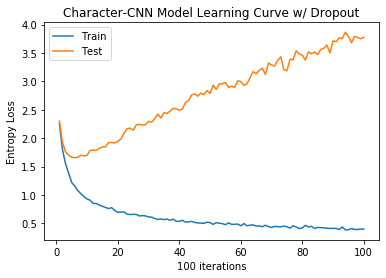

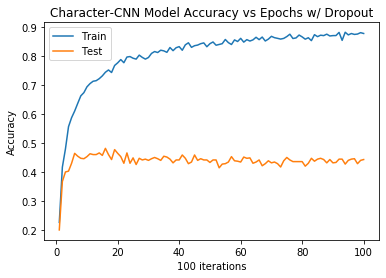

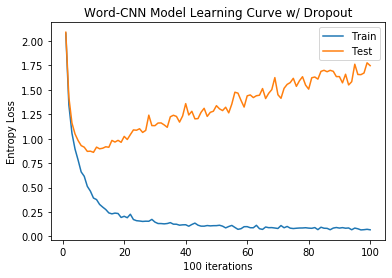

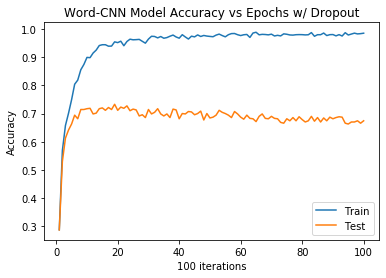

In [7]:
main()